### Instructions
 * The research question is can we use algorithms and compute to identify clothing items? Specifically, can we determine which algorithm and compute methodology provides us the most efficient approach for classifying simple fashion images?
 * Using the base samples available from Zalando Research:
  * https://github.com/zalandoresearch/fashion-mnist
  * Review the data -- clean as appropriate
  * Provide an initial data analysis
 * Implement at least two approaches for classifying the digits -- examples below:
  * Naïve bayes
  * Neural Networks
  * Keras
  * Azure ML
  * IBM DSX
  * Boosted trees
  * Linear classification
  * Your choice

* Answer the following questions:
  * What is the accuracy of each method?
  * What are the trade-offs of each approach?
  * What is the compute performance of each approach

## Importing Libraries

In [67]:

import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip
import seaborn as sns
color = sns.color_palette()
import lightgbm as lgb

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model\

from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss, precision_recall_curve, average_precision_score, roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score

import keras
from keras import backend as K, regularizers
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, BatchNormalization, Input, Lambda
from keras.layers import
from keras.losses import mse, binary_crossentropy

# Autoencoder Model

## Building Autoencoder Model

### Reading in the data, Splitting data into Training/Testing datasets, and reshapping the images

In [14]:
train = pd.read_csv('fashion-mnist_train.csv')
test = pd.read_csv('fashion-mnist_test.csv')

In [49]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [50]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


### Adding in random noise to the image data

In [51]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

### Printing some examples of the clothing data with the noise added

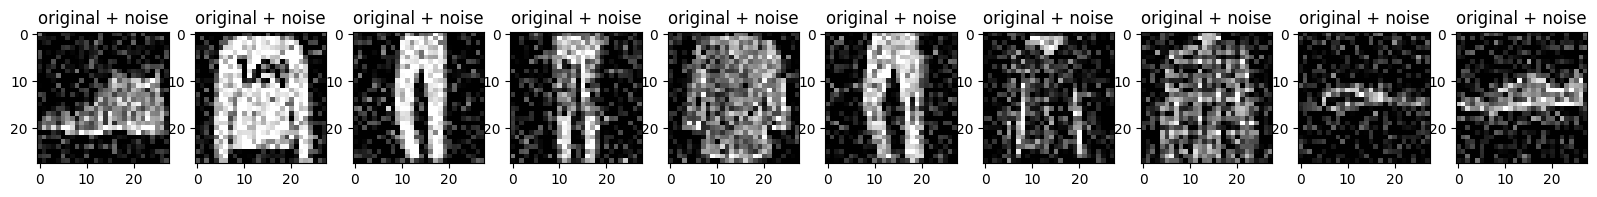

In [52]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

Creating a class called "Denoise" that will take the images that have the random noise added, and try to predict what type of clothing that noise-added image is.

In [53]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [54]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

## Training the Autoencoder Model

In [77]:
history = autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                verbose=1,
                validation_data=(x_test_noisy, x_test))
score = autoencoder.evaluate(x_test_noisy, x_test, verbose=0)

Epoch 1/10
1875/1875 [==============================] - 44s 23ms/step - loss: 0.0069 - val_loss: 0.0071
Epoch 2/10
1875/1875 [==============================] - 46s 24ms/step - loss: 0.0069 - val_loss: 0.0070
Epoch 3/10
1875/1875 [==============================] - 49s 26ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 4/10
1875/1875 [==============================] - 42s 23ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 5/10
1875/1875 [==============================] - 42s 22ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 6/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0067 - val_loss: 0.0067
Epoch 7/10
1875/1875 [==============================] - 41s 22ms/step - loss: 0.0067 - val_loss: 0.0067
Epoch 8/10
1875/1875 [==============================] - 42s 22ms/step - loss: 0.0067 - val_loss: 0.0067
Epoch 9/10
1875/1875 [==============================] - 41s 22ms/step - loss: 0.0066 - val_loss: 0.0067
Epoch 10/10
1875/1875 [==============================] - 42s 23m

### Model Structure and Summary

In [58]:
autoencoder.encoder.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 14, 14, 16)        160       
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [59]:
autoencoder.decoder.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_6 (Conv2DT  (None, 14, 14, 8)        584       
 ranspose)                                                       
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


In [60]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

### Plotting the noise-added images with the reconstructed images
The reconstructed images are generated images from the random noise-added images.

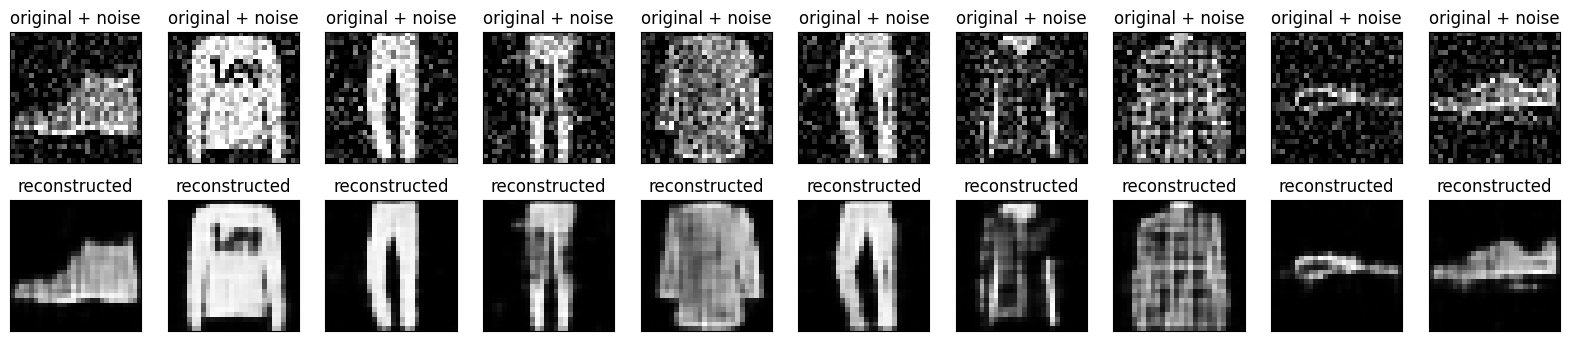

In [61]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## Keras Model Evaluation and Performance

In [81]:
# Predict probabilities for each class
predicted_probs = autoencoder.predict(x_test)

# Get the class indices with the highest probabilities
predicted_classes = np.argmax(predicted_probs, axis=1)

# Get the indices of the true class labels for validation data
y_true = np.argmax(x_test, axis=1)

# Find indices of correct and incorrect predictions
correct = np.nonzero(predicted_classes == y_true)[0]
incorrect = np.nonzero(predicted_classes != y_true)[0]

313/313 [==============================] - 2s 7ms/step


Accuracy: 37.76%
313/313 [==============================] - 3s 9ms/step - loss: 0.0066
Loss: 0.0066475714556872845


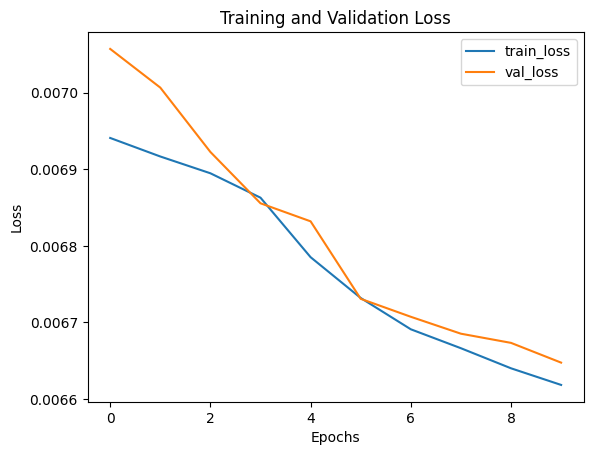

In [80]:
# Calculate accuracy
accuracy = len(correct) / (len(correct) + len(incorrect))
print("Accuracy: {:.2%}".format(accuracy))

# Print loss
loss = autoencoder.evaluate(x_test_noisy, x_test)
print("Loss:", loss)

# Create a loss graph
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

In [90]:
print('Test loss:', score)
# print('Test accuracy:', max(history.history["val_loss"]))

Test loss: 0.0066475714556872845


The Autoencoder Test/Validation model performs just slightly worse than the training model, with the test loss of 0.665% and training loss of 0.660%.

Training the Autoencoder Model was substantially faster than the time it took to train the Keras Model. However, the Keras Model did have a much higher accuracy, which I would take over the Autoencoder model.

### Sources:
* [TensorFlow Website](https://www.tensorflow.org/tutorials/generative/autoencoder)
* [Kaggle Repo](https://www.kaggle.com/code/aksahaha/autoencoders)